# Задача классификации, дерево решений и метод ближайших соседей

Самые популярные задачи в машинном обучении:
 - классификация – отнесение объекта к одной из категорий на основании его признаков 
 - регрессия – прогнозирование количественного признака объекта на основании прочих его признаков 
 - кластеризация – разбиение множества объектов на группы на основании признаков этих объектов так, чтобы внутри групп объекты были похожи между собой, а вне одной группы  – менее похожи
 - детекция аномалий – поиск объектов, "сильно непохожих" на все остальные в выборке либо на какую-то группу объектов
 - сокращение пространства признаков  – отбрасывание не существенных\скорелированных признаков 

<img src="gifs/ml_map.png" width="1000">

Сейчас мы разбираем алгоритмы машинного обучения, которые обучаются *с учителем* (supervised learning). 
В задаче обучения с учителем у нас есть:
- выборка из объектов и признаков
- целевой признак по объектам выборки, т.е. то что мы собираемся прогнозировать на таких же новых объектах

#### При решении любой задачи важно идти от самых простых и интерпретируемых методов к более сложным, чтобы наглядно на метриках качества иметь доказательство того, что использование сложной black-box модели оправдано или нет.

#### В прошлом ноутбуке мы попробовали использовать линейные методы. Но на практике очень часто данные нельзя разделить на необходимые классы с помощью линейной гиперпроскости, поэтому сегодня посмотрим нелинейные модели машинного обучения,  которые сложнее, но все еще поддаются интерпретации (white-box).

<img src="gifs/linear.jpeg"/><br>

## Дерево решений 

Пример дерева решения в задаче кредитного скоринга:
<img src="https://habrastorage.org/files/194/9b6/ae9/1949b6ae97ab4fc9b1a37fbf182eda8f.gif"/><br>
В этом случае можно сказать, что решается задача бинарной классификации (целевой класс имеет два значения: "Выдать кредит" и "Отказать") по признакам "Возраст", "Наличие дома", "Доход" и "Образование".

Дерево решений как алгоритм машинного обучения: объединение логических правил вида "Значение признака $a$ меньше $x$ И Значение признака $b$ меньше $y$ ... => Класс 1" в структуру данных "Дерево". 

Преимущества в том, что деревья легко интерпретируемы, понятны человеку. Например, по схеме на рисунке выше можно объяснить заемщику, почему ему было отказано в кредите. Скажем, потому, что у него нет дома и доход меньше 5000

## Структура дерева решений

<img src="http://datareview.info/wp-content/uploads/2014/10/dec_tree.gif"/><br>

## Как строится дерево решений

Алгоритм обучения: нужно находить правила (предикаты), на основе которых разбивать тренировочный набор данных, таким образом, чтобы уменьшалось среднее значение энтропии. 

Разбив исходный набор данных на две части по некому предикату, можно рассчитать энтропию каждого подмножества, после чего рассчитать среднее значение энтропии — если оно окажется меньшим чем энтропия исходного множества, значит предикат содержит некую обобщающую информацию о данных.


Можно убедиться в том, что построенное в следующем примере дерево является в некотором смысле оптимальным – потребовалось только 5 "вопросов" (условий на признак $x$), чтобы "подогнать" дерево решений под обучающую выборку, то есть чтобы дерево правильно классифицировало любой обучающий объект. При других условиях разделения выборки дерево получится глубже. 

<img src="https://habrastorage.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png"/><br>

Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0, что соответствует представлению, что группа шариков одного цвета – упорядоченная. 

В итоге мы построили дерево решений, предсказывающее цвет шарика по его координате. Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков), поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков). Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений, пусть даже оно и не идеально разбивает по цветам обучающую выборку. Эту проблему, переобучение, мы еще рассмотрим далее. 

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

#### Пример
Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Сгенерируем данные. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

In [2]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

In [12]:
train_data

array([[-0.21272722,  1.04060298],
       [ 0.61362669,  0.07918525],
       [ 0.94905522,  0.52103091],
       [ 0.76766656, -2.21030379],
       [-0.64263221,  0.26440387],
       [-3.67514098,  0.19863668],
       [-0.37017154, -0.39487818],
       [ 0.78782801, -0.2668414 ],
       [-0.75908922, -0.11541394],
       [-1.82256264,  0.25914746],
       [ 1.15769417, -0.1954832 ],
       [ 1.47575068, -0.16897019],
       [-0.59035068,  1.29777155],
       [ 0.23672721,  0.66941076],
       [ 0.9221679 ,  0.02903844],
       [-1.07709852,  0.62374201],
       [ 0.27470209, -0.70943719],
       [-0.10240595,  0.55326391],
       [ 0.10941464,  0.8182437 ],
       [-0.54833403, -0.40390973],
       [-2.27779715,  0.48969806],
       [-0.82706914,  1.47244919],
       [-0.15300648,  0.1569419 ],
       [-0.68344805,  1.05623576],
       [ 0.58897404, -0.33578542],
       [-1.13042235,  0.65375735],
       [ 0.79323556, -1.46304148],
       [ 0.72141609,  0.57763054],
       [-0.18011874,

Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации.

In [2]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

Отобразим данные. Неформально, задача классификации в этом случае – построить какую-то "хорошую" границу, разделяющую 2 класса (красные точки от желтых). Если утрировать, то машинное обучение в этом случае сводится к тому, как выбрать хорошую разделяющую границу. Возможно,  прямая будет слишком простой границей, а какая-то сложная кривая, огибающая каждую красную точку – будет слишком сложной и будем много ошибаться на новых примерах из того же распределения, из которого пришла обучающая выборка. Интуиция подсказывает, что хорошо на новых данных будет работать какая-то *гладкая* граница, разделяющая 2 класса, или хотя бы просто прямая (в $n$-мерном случае - гиперплоскость). 

In [10]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [19]:
train_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

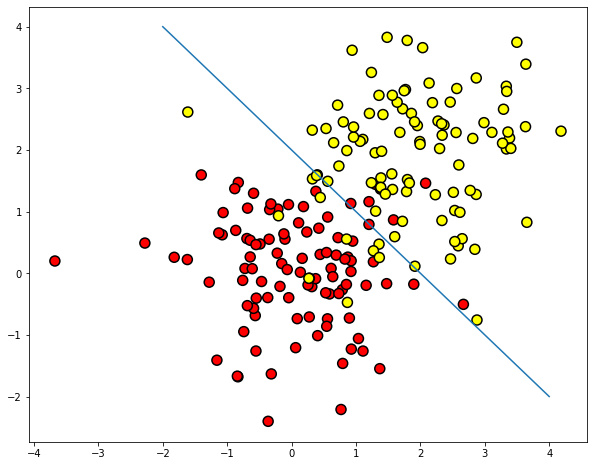

In [20]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1));

Попробуем разделить эти два класса, обучив дерево решений. В дереве будем использовать параметр `max_depth`, ограничивающий глубину дерева. Визуализируем полученную границу разделения класссов.

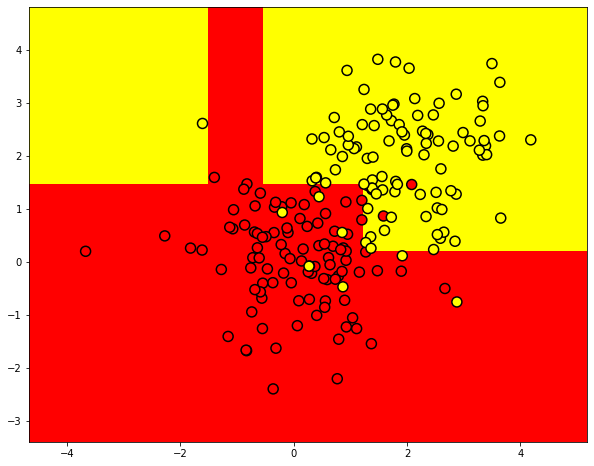

In [38]:
from sklearn.tree import DecisionTreeClassifier

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

А как выглядит само построенное дерево? Видим, что дерево "нарезает" пространство на 7 прямоугольников (в дереве 7 листьев). В каждом таком прямоугольнике прогноз дерева будет константным, по превалированию объектов того или иного класса.

In [40]:
# используем .dot формат для визуализации дерева
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

<!-- 
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file='../../img/small_tree.dot', filled=True)
!dot -Tpng '../../img/small_tree.dot' -o '../../img/small_tree.png'

<img src='../../img/small_tree.png'> -->

**Как "читается" такое дерево?**

В начале было 200 объектов, 100 - одного класса и 100 – другого. Энтропия начального состояния была максимальной – 1. Затем было сделано разбиение объектов на 2 группы в зависимости от сравнения признака $x_1$ со значением $0.567$ (найдите этот участок границы на рисунке выше, до дерева). При этом энтропия и в левой, и в правой группе объектов уменьшилась. И так далее, дерево строится до глубины 3. При такой визуализации чем больше объектов одного класса, тем  цвет вершины ближе к темно-оранжевому и, наоборот, чем больше объектов второго класса, тем ближе цвет к темно-синему. В начале объектов одного касса поровну, поэтому корневая вершина дерева – белого цвета.

### Как дерево решений работает с количественными признаками

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак. 

Рассмотрим это на игрушечном примере. Пусть есть следующая выборка:

In [3]:
data = pd.DataFrame({'Возраст': [17,64,18,20,38,49,55,25,29,31,33], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

Отсортируем ее по возрастанию возраста.

In [4]:
data.sort_values(by=['Возраст'])

,Возраст,Невозврат кредита
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


Обучим на этих данных дерево решений (без ограничения глубины) и посмотрим на него.

**Не забываем везде во всех алгоритмах ставить random state для воспроизводимости результатов**

In [5]:
data.columns


Index(['Возраст', 'Невозврат кредита'], dtype='object')

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree

In [30]:
clf = DecisionTreeClassifier(random_state=17)

In [31]:
# X_train, X_test, y_train, y_test = train_test_split(data['Возраст'], data['Невозврат кредита'], stratify=data['Невозврат кредита'], random_state=42)

In [32]:
clf.fit(data['Возраст'].values.reshape(-1,1), data['Невозврат кредита'].values)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

In [33]:
data['Возраст']

0     17
1     64
2     18
3     20
4     38
5     49
6     55
7     25
8     29
9     31
10    33
Name: Возраст, dtype: int64

In [29]:
data[data.columns[1]].values.reshape(-1,1)

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1]])

In [34]:
export_graphviz(clf, feature_names=['Возраст'], 
out_file='small_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng 'small_tree.dot' -o 'small_tree.png'

In [35]:
tree.export_graphviz(clf)

'digraph Tree {\nnode [shape=box] ;\n0 [label="X[0] <= 43.5\\ngini = 0.496\\nsamples = 11\\nvalue = [5, 6]"] ;\n1 [label="X[0] <= 19.0\\ngini = 0.375\\nsamples = 8\\nvalue = [2, 6]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="gini = 0.0\\nsamples = 2\\nvalue = [0, 2]"] ;\n1 -> 2 ;\n3 [label="X[0] <= 22.5\\ngini = 0.444\\nsamples = 6\\nvalue = [2, 4]"] ;\n1 -> 3 ;\n4 [label="gini = 0.0\\nsamples = 1\\nvalue = [1, 0]"] ;\n3 -> 4 ;\n5 [label="X[0] <= 30.0\\ngini = 0.32\\nsamples = 5\\nvalue = [1, 4]"] ;\n3 -> 5 ;\n6 [label="gini = 0.0\\nsamples = 2\\nvalue = [0, 2]"] ;\n5 -> 6 ;\n7 [label="X[0] <= 32.0\\ngini = 0.444\\nsamples = 3\\nvalue = [1, 2]"] ;\n5 -> 7 ;\n8 [label="gini = 0.0\\nsamples = 1\\nvalue = [1, 0]"] ;\n7 -> 8 ;\n9 [label="gini = 0.0\\nsamples = 2\\nvalue = [0, 2]"] ;\n7 -> 9 ;\n10 [label="gini = 0.0\\nsamples = 3\\nvalue = [3, 0]"] ;\n0 -> 10 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n}'

**По какому правилу дерево нарезает листья? (Смотри на значения)**

In [37]:
# Если возраст <= какому то числу

**Нарисуйте структуру дерева как в примерах выше**

In [38]:
from PIL import Image
img=Image.open('small_tree.png')
img.show()

<!--
export_graphviz(age_tree, feature_names=['Возраст'], 
                out_file='../../img/age_tree.dot', filled=True)
!dot -Tpng '../../img/age_tree.dot' -o '../../img/age_tree.png'
<img src='../../img/age_tree.png'>
-->

Рассмотрим пример посложнее: добавим признак "Зарплата" (тыс. рублей/месяц).

In [39]:
data2 = pd.DataFrame({'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

Если отсортировать по возрасту, то целевой класс ("Невозврат кредита") меняется (с 1 на 0 или наоборот) 5 раз. А если отсортировать по зарплате – то 7 раз. Как теперь дерево будет выбирать признаки? Посмотрим.

In [40]:
data2.sort_values('Возраст')

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [52]:
data2 = data2.sort_values('Зарплата')
data2.

,Возраст,Зарплата,Невозврат кредита
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


In [64]:
data2.shape

(11, 3)

**Обучите модель на новом датасете и нарисуйте структуру дерева**

In [109]:
clf1 = DecisionTreeClassifier(random_state=17, criterion='entropy')
# clf2 = DecisionTreeClassifier(random_state=17)
# clf3 = DecisionTreeClassifier(random_state=17)

In [110]:
data2['Невозврат кредита'].values.shape

(11,)

In [111]:
clf1.fit(data2[['Возраст', 'Зарплата']].values, data2['Невозврат кредита'].values)
# clf1.fit(data2['Возраст'].values.reshape(-1, 1), data2['Невозврат кредита'].values)

# clf2.fit(data2['Зарплата'].values.reshape(-1, 1), data2['Невозврат кредита'].values)

clf3.fit(data2[data2.columns[:2]].values.reshape(-1, 2), data2['Невозврат кредита'].values)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

In [112]:
# export_graphviz(clf1, feature_names='Возраст', out_file='clf1.dot', filled=True)
export_graphviz(clf1, feature_names='Зарплата', out_file='clf1.dot', filled=True)
# export_graphviz(clf3, feature_names='Возраст', out_file='clf1.dot', filled=True)

In [113]:
export_graphviz(clf1, feature_names=['Возраст', 'Зарплата'], out_file='clf3_Возраст.dot', filled=True)
!dot -Tpng 'clf3_Возраст.dot' -o 'clf3_Возраст.png'
Image.open('clf3_Возраст.png').show()

<!--
export_graphviz(age_sal_tree, feature_names=['Возраст', 'Зарплата'], 
                out_file='../../img/age_sal_tree.dot', filled=True)
!dot -Tpng '../../img/age_sal_tree.dot' -o '../../img/age_sal_tree.png'
<img src='../../img/age_sal_tree.png'>
-->

**Вывод:** самая простая эвристика для обработки количественных признаков в дереве решений: количественный признак сортируется по возрастанию, и в дереве проверяются только те пороги, при которых целевой признак меняет значение. 




Дополнительно, когда в данных много количественных признаков, и у каждого много уникальных значений, могут отбираться не все пороги, описанные выше, а только топ-N, дающих максимальный прирост все того же критерия. То есть, по сути, для каждого порога строится дерево глубины 1, считается насколько снизилась энтропия (или неопределенность Джини) и выбираются только лучшие пороги, с которыми стоит сравнивать количественный признак. 


### Основные параметры дерева

В принципе дерево решений можно построить до такой глубины, чтоб в каждом листе был ровно один объект. Но на практике это не делается из-за того, что такое дерево будет *переобученным* – оно слишком настроится на обучающую выборку и будет плохо работать на прогноз на новых данных. Где-то внизу дерева, на большой глубине будут появляться разбиения по менее важным признакам. Если утрировать, может оказаться так, что из всех 4 клиентов, пришедших в банк за кредитом в зеленых штанах, никто не вернул кредит. Но мы не хотим, чтобы наша модель классификации порождала такие специфичные правила. 

Основные способы борьбы с переобучением в случае деревьев решений:
 - искусственное ограничение глубины или минимального числа объектов в листе: построение дерева просто в какой-то момент прекращается;
 - стрижка дерева (*pruning*). При таком подходе дерево сначала строится до максимальной глубины, потом постепенно, снизу вверх, некоторые вершины дерева убираются за счет сравнения по качеству дерева с данным разбиением и без него (сравнение проводится с помощью *кросс-валидации*, о которой чуть ниже). Подробнее можно почитать в  материалах [репозитория](https://github.com/esokolov/ml-course-msu) Евгения Соколова.

### Класс DecisionTreeClassifier в Scikit-learn
Основные параметры класса [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

- `max_depth` – максимальная глубина дерева
- `max_features` - максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди *всех* признаков)
- `min_samples_leaf` – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как мимимум для 5 объектов

Параметры дерева надо настраивать в зависимости от входных данных, и делается это обычно с помощью *кросс-валидации*,  про нее чуть ниже.


# Метод ближайших соседей

Метод ближайших соседей (k Nearest Neighbors, или kNN) — тоже очень популярный метод классификации, также иногда используемый в задачах регрессии. Это, наравне с деревом решений, один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей, какие преобладают, таков и ты. Формально основой метода является гипотезой компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных. 

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:
 - Вычислить расстояние до каждого из объектов обучающей выборки
 - Отобрать $k$ объектов обучающей выборки, расстояние до которых минимально
 - Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей
 
**Особенность:**
Алгоритм ленивый - вычисления начинаются только в момент классификации тестового примера, а заранее, только при  наличии обучающих примеров, никакая модель не строится.
 
Качество классификации методом ближайших соседей зависит от нескольких параметров:
 - число соседей
 - метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100. 
 - веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")

 
### Класс KNeighborsClassifier в Scikit-learn
Основные параметры класса sklearn.neighbors.KNeighborsClassifier:
 - `weights`: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
 - `algorithm` (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем - расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
 - `leaf_size` (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
 - `metric`: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

# Выбор параметров модели и кросс-валидация 

Главная задача обучаемых алгоритмов – их способность *обобщаться*, то есть хорошо работать на новых данных. Поскольку, на новых данных мы сразу не можем проверить качество построенной модели (нам ведь надо для них сделать прогноз, то есть истинных значений целевого признака мы для них не знаем), то надо пожертвовать небольшой порцией данных, чтоб на ней проверить качество модели. 

Чаще всего это делается одним из 2 способов:

 - отложенная выборка (*held-out/hold-out set*). При таком подходе мы оставляем какую-то долю обучающей выборки (как правило от 20% до 40%), обучаем модель на остальных данных (60-80% исходной выборки) и считаем некоторую метрику качества модели (например, самое простое – долю правильных ответов в задаче классификации) на отложенной выборке. 
 - кросс-валидация (*cross-validation*, на русский еще переводят как скользящий или перекрестный контроль). Тут самый частый случай – K-fold кросс-валидация
 <img src='https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/img/cross_validation.png'><br>
 
Тут модель обучается K раз на разных (K-1) подвыборках исходной выборки (белый цвет), а проверяется на одной подвыборке (каждый раз на разной, оранжевый цвет). 
Получаются $K$ оценок качества модели, которые обычно усредняются, выдавая среднюю оценку качества классификации/регресии на кросс-валидации.

Кросс-валидация дает лучшую по сравнению отложенной выборкой оценку качества модели на новых данных. Но кросс-валидация вычислительно дорогостоящая, если данных много. 

## Деревья решений и метод ближайших соседей в задаче прогнозирования оттока клиентов телеком-оператора

Считаем данные в DataFrame и проведем предобработку.

1. В качестве целевой переменной (y) выделяем `Churn` - преобразуем в int
2. Для столбцов International plan и Voice mail plan применяем функцию [pd.factorize](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html)
3. Штаты пока сохраним в отдельный объект Series, но удалим из датафрейма. 

In [114]:
df = pd.read_csv('data/telecom_churn.csv')

In [124]:
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == False else 1)
# можно и так
# df['Churn'] = df['Churn'].factorize()[0]

In [50]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [125]:
df.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

In [129]:
df['International plan'] = df['International plan'].factorize()[0]
df['Voice mail plan'] = df['Voice mail plan'].factorize()[0]

In [131]:
s = pd.Series(df.State)

In [132]:
dfdf.drop(columns='State').columns

Index(['Account length', 'Area code', 'International plan', 'Voice mail plan',
       'Number vmail messages', 'Total day minutes', 'Total day calls',
       'Total day charge', 'Total eve minutes', 'Total eve calls',
       'Total eve charge', 'Total night minutes', 'Total night calls',
       'Total night charge', 'Total intl minutes', 'Total intl calls',
       'Total intl charge', 'Customer service calls', 'Churn'],
      dtype='object')

Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели.

**Незабываем указывать random_state везде где можно!!!**

Обучим 2 модели – дерево решений и kNN, пока не знаем, какие параметры хороши, поэтому наугад: глубину дерева берем 5, число ближайших соседей – 10.

**Незабываем указывать random_state везде где можно!!!**

Качество прогнозов будем проверять с помощью простой метрики – доли правильных ответов (accuracy - не подходит для несбалансированных выборок) 

In [30]:
from sklearn.metrics import accuracy_score

Сделаем прогнозы обоих методов для отложенной выборки 

Теперь настроим параметры **дерева** на кросс-валидации. Настраивать будем максимальную глубину и максимальное используемое на каждом разбиении число признаков.

Задайте сетку гиперпараметров для GridSearch `max_depth` от 1 до 10, для `max_features` от 1 до 18

In [34]:
tree_params = ##your code

Суть того, как работает GridSearchCV: для каждой уникальной пары значений  параметров `max_depth` и `max_features` будет проведена 5-кратная кросс-валидация и выберется лучшее сочетание параметров.


Инициализируйте GridSearch с заданной сеткой для подбора параметров алгоритма и проведите отбор(fit)

In [33]:
from sklearn.model_selection import GridSearchCV, cross_val_score

Выведите лучшее сочетание параметров и соответствующую среднюю долю правильных ответов на кросс-валидации:

Сделайте предсказание  на выборке holdout и замерьте accuracy

Теперь попробуем настроить число соседей в алгоритме kNN.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

**т.к. для алгоритма ближайщих соседей нам так же нужно использовать предобработку(скалирование данных), для  объединения нескольких шагов удобно использовать Pipeline**

#### Подробно читаем про Pipeline и как обращаться к разным его составляющим\параметрам этих составляющих здесь:
https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976

In [41]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

Задайте сетку подбора параметров для `n_neighbors` от 1 до 10. Т.к. мы используем Pipeline, в сетке в качестве ключа нужно использовать `название_шага_из_pipeline__параметр`

In [42]:
knn_params = ##your code

Задайте GridSeacrh и зафитьте

Выведите лучшее сочетание параметров и соответствующую среднюю долю правильных ответов на кросс-валидации:

Сделайте предсказание на выборке holdout и замерьте accuracy

Из двух моделей выберите лучшую. Если это оказалось дерево, визуализируйте его.

<!--
export_graphviz(tree_grid.best_estimator_, feature_names=df.columns, 
                out_file='../../img/churn_tree.dot', filled=True)
!dot -Tpng '../../img/churn_tree.dot' -o '../../img/churn_tree.png'

<img src='../../img/churn_tree.png'>
-->

## Плюсы и минусы деревьев решений

**Плюсы:**
 - Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, то отказать в кредите". Это свойство называют интерпретируемостью модели;
 - Деревья решений могут легко визуализироваться, то есть может "интерпретироваться" (строгого определения я не видел) как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве);
 - Быстрые процессы обучения и прогнозирования;
 - Малое число параметров модели;
 - Поддержка и числовых, и категориальных признаков.
 
**Минусы:**
 - У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных, вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов), поэтому и правила классификации могут сильно изменяться, что ухудшает интерпретируемость модели;
 - Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатной оси), и на практике дерево решений по качеству классификации уступает некоторым другим методам;
 - Необходимость отсекать ветви дерева (pruning) или устанавливать минимальное число элементов в листьях дерева или максимальную глубину дерева для борьбы с переобучением. Впрочем, переобучение - проблема всех методов машинного обучения;
 - Нестабильность. Небольшие изменения в данных могут существенно изменять построенное дерево решений. С этой проблемой борются с помощью ансамблей деревьев решений (рассмотрим далее);
 - Проблема поиска оптимального дерева решений (минимального по размеру и способного без ошибок классифицировать выборку) NP-полна, поэтому на практике используются эвристики типа жадного поиска признака с максимальным приростом информации, которые не гарантируют нахождения глобально оптимального дерева;
 - Модель умеет только интерполировать, но не  экстраполировать (это же верно и для леса и бустинга на деревьях). То есть дерево решений делает константный прогноз для объектов, находящихся в признаковом пространстве вне параллелепипеда, охватывающего все объекты обучающей выборки. В нашем примере с желтыми и синими шариками это значит, что модель дает одинаковый прогноз для всех шариков с координатой > 19 или < 0.

### Плюсы и минусы метода ближайших соседей

Плюсы:
 - Простая реализация
 - Можно адаптировать под нужную задачу выбором метрики или ядра (в двух словах: ядро может задавать операцию сходства для сложных объектов типа графов, а сам подход kNN остается тем же).
 - Неплохая интерпретация, можно объяснить, почему тестовый пример был классифицирован именно так. Хотя этот аргумент можно атаковать: если число соседей большое, то интерпретация ухудшается (условно: "мы не дали ему кредит, потому что он похож на 350 клиентов, из которых 70 – плохие, что на 12% больше, чем в среднем по выборке").
 
Минусы:
 - Метод считается быстрым в сравнении, например, с композициями алгоритмов, но в реальных задачах, как правило, число соседей, используемых для классификации, будет большим (100-150), и в таком случае алгоритм будет работать не так быстро, как дерево решений;
 - Если в наборе данных много признаков, то трудно подобрать подходящие веса и определить, какие признаки не важны для классификации/регрессии;
 - Зависимость от выбранной метрики расстояния между примерами. Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован. Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени;
 - Нет теоретических оснований выбора определенного числа соседей - только перебор (впрочем, чаще всего это верно для всех гиперпараметров всех моделей). В случае малого числа соседей метод чувствителен к выбросам, то есть склонен переобучаться;

**За основу взят [этот пост](https://habr.com/ru/company/ods/blog/322534/) Юрия Кашницкого.**
Там же можно подробнее почитать:
- [сложные случаи для деревьев решений](https://habr.com/ru/company/ods/blog/322534/#slozhnyy-sluchay-dlya-derevev-resheniy)
- [сложные случаи для к-ближайших соседей](https://habr.com/ru/company/ods/blog/322534/#slozhnyy-sluchay-dlya-metoda-blizhayshih-sosedey)

 <img src='https://i.gifer.com/Xbb1.gif'><br>